<a href="https://colab.research.google.com/github/mightyssge/ING-DATOS/blob/main/Notebooks/ABD_MLlib_Regresion_Arboles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <img style="float: left; padding: 0px 10px 0px 0px;" src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/a0/Universidad_de_Lima_logo.png/220px-Universidad_de_Lima_logo.png"  width="120" />  MLlib: Regresión (II)
**Profesor:** Enver G. Tarazona Vargas <br>
**Curso:** Analítica con Big Data <br>
**FACULTAD DE INGENIERÍA - CARRERA DE INGENIERÍA DE SISTEMAS**<br>

# Ejemplo 2 de Regresión: Árboles de decisión (árboles de regresión)

In [1]:
!apt-get install -y openjdk-11-jdk

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  at-spi2-core ca-certificates-java fonts-dejavu-core fonts-dejavu-extra
  gsettings-desktop-schemas java-common libatk-bridge2.0-0 libatk-wrapper-java
  libatk-wrapper-java-jni libatk1.0-0 libatk1.0-data libatspi2.0-0
  libpcsclite1 libxcomposite1 libxt-dev libxtst6 libxxf86dga1
  openjdk-11-jdk-headless openjdk-11-jre openjdk-11-jre-headless
  session-migration x11-utils
Suggested packages:
  default-jre pcscd libxt-doc openjdk-11-demo openjdk-11-source visualvm
  libnss-mdns fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  | fonts-wqy-zenhei fonts-indic mesa-utils
The following NEW packages will be installed:
  at-spi2-core ca-certificates-java fonts-dejavu-core fonts-dejavu-extra
  gsettings-desktop-schemas java-common libatk-bridge2.0-0 libatk-wrapper-java
  libatk-wrapper-java-jni libatk1.0-0 libatk1.0-data libatspi2.0

In [2]:
# Solo si se corre en Google Colab
!pip install -q pyspark

In [3]:
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression

spark = SparkSession.builder.getOrCreate()

In [4]:
# Carga de archivos
!wget -q https://raw.githubusercontent.com/etarazonav/650044-ABD-ULIMA/refs/heads/main/Datos/Clientes.csv

## 1.&nbsp;Lectura de Datos

Se examinará el dataset llamado "Clientes" que contiene datos del sitio web y de la aplicación móvil de una compañía. Se desea construir un modelo de regresión que prediga el gasto anual del cliente en los productos de la compañía.

In [5]:
# Cargar los datos
df = spark.read.csv("Clientes.csv", inferSchema=True, header=True)

## 2.&nbsp;Pre-procesamiento

Para regresión con MLlib los datos deben encontrarse en dos columnas: `("etiquetas","atributos")`, donde `atributos` es una sola columna que contiene una lista con todos los atributos. Para poder crear esta columna `atributos` se debe agrupar los atributos usando un `VectorAssembler`.

In [6]:
from pyspark.ml.feature import VectorAssembler

# Se utilizará los siguientes atributos bajo el nombre "atributos"
vassembler = VectorAssembler(inputCols=['Promedio sesion',
                                        'Tiempo en App',
                                        'Tiempo en SitioWeb',
                                        'Tiempo de Membresia'],
                             outputCol="Atributos")
# Aplicar a los datos
df2 = vassembler.transform(df)
# Conjunto de datos para regresión: "atributos, gasto anual"
df_final = df2.select("Atributos", 'Gasto Anual')
# Separación en conjunto de entrenamiento y evaluación
train_data, test_data = df_final.randomSplit([0.7, 0.3])

## 3.&nbsp;Entrenamiento del Modelo de Regresión

In [7]:
from pyspark.ml.regression import DecisionTreeRegressor, RandomForestRegressor

In [9]:
# Creación de un objeto de Regresión Lineal
dtreg = DecisionTreeRegressor(featuresCol="Atributos",
                              labelCol='Gasto Anual',
                              predictionCol= "Predicción")

# Entrenamiento del modelo (con el conjunto de entrenamiento)
modeloDT = dtreg.fit(train_data)

In [10]:
modeloDT

DecisionTreeRegressionModel: uid=DecisionTreeRegressor_c3513592edb7, depth=5, numNodes=63, numFeatures=4

Predicción en el conjunto de entrenamiento

In [11]:
predicciones = modeloDT.transform(train_data)
predicciones.show(5, truncate=False)

+-----------------------------------------------------------------------------+-----------------+------------------+
|Atributos                                                                    |Gasto Anual      |Predicción        |
+-----------------------------------------------------------------------------+-----------------+------------------+
|[30.3931845423455,11.80298577760313,36.315763151803424,2.0838141920346707]   |319.9288698031936|331.41954876470464|
|[30.737720372628182,12.636606052000127,36.213763093698624,3.3578468423262944]|461.7807421962299|486.9115444369875 |
|[30.83643267477343,13.100109538542807,35.907721429679654,3.361612984538193]  |467.5019004269896|492.26853598084455|
|[30.879484344127498,13.280432242922114,36.93615937845674,3.5851606351613436] |490.2065999848547|492.26853598084455|
|[30.971675643887767,11.731364294077403,36.07455114016891,4.4263640805293125] |494.6386097568927|540.5245111593531 |
+---------------------------------------------------------------

RMSE en el conjunto de entrenamiento

In [12]:
from pyspark.ml.evaluation import RegressionEvaluator

eval_rmse = RegressionEvaluator(labelCol="Gasto Anual", predictionCol="Predicción",
                                metricName="rmse")

eval_mae = RegressionEvaluator(labelCol="Gasto Anual", predictionCol="Predicción",
                               metricName="mae")

eval_mse = RegressionEvaluator(labelCol="Gasto Anual", predictionCol="Predicción",
                               metricName="mse")

eval_r2 = RegressionEvaluator(labelCol="Gasto Anual", predictionCol="Predicción",
                               metricName="r2")

In [13]:
rmse = eval_rmse.evaluate(predicciones)
mae = eval_mae.evaluate(predicciones)
mse = eval_mse.evaluate(predicciones)
r2 = eval_r2.evaluate(predicciones)

print("MAE del conjunto de entrenamiento:", mae)
print("RMSE del conjunto de entrenamiento:", rmse)
print("MSE del conjunto de entrenamiento:", mse)
print("R^2 del conjunto de entrenamiento:", r2)

MAE del conjunto de entrenamiento: 18.22194955471638
RMSE del conjunto de entrenamiento: 23.19388680979852
MSE del conjunto de entrenamiento: 537.9563853457457
R^2 del conjunto de entrenamiento: 0.914085065521633


Se realizará una figura de los valores reales ("Gasto Anual") y los valores predichos ("Predicción") para inspección visual de la predicción.

In [14]:
import matplotlib.pyplot as plt

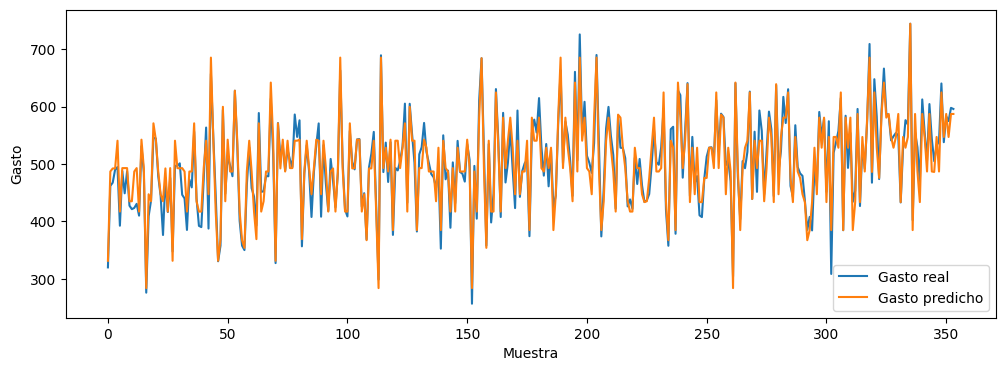

In [15]:
# Recuperar las columnas de interés: Gasto Anual y Predicción
yreal = predicciones.select('Gasto Anual').collect()
ypred = predicciones.select('Predicción').collect()

# Figuras
plt.figure(figsize=(12, 4))
plt.plot(yreal)
plt.plot(ypred)
plt.legend(['Gasto real', 'Gasto predicho'])
plt.xlabel('Muestra'); plt.ylabel('Gasto');

## 4.&nbsp;Evaluación del Modelo

In [16]:
# Aplicación del modelo entrenado al conjunto de prueba (test)
predicciones = modeloDT.transform(test_data)
predicciones.show(5, truncate=False)

+----------------------------------------------------------------------------+------------------+------------------+
|Atributos                                                                   |Gasto Anual       |Predicción        |
+----------------------------------------------------------------------------+------------------+------------------+
|[29.532428967057943,10.961298400154098,37.42021557502538,4.046423164299585] |408.6403510726275 |492.82382368068386|
|[30.4925366965402,11.562936246652605,35.97656497174036,1.4816166268553612]  |282.4712457199145 |331.41954876470464|
|[30.57436368417137,11.351049011250833,37.08884657968332,4.078308001651641]  |442.06441375806565|492.82382368068386|
|[30.81620064887634,11.851398743073142,36.925043038878634,1.0845853030221226]|266.086340948469  |353.9580918845322 |
|[31.128090049616628,13.278956228597714,37.38718052656558,4.626075291951958] |557.2526867470547 |542.3249298944957 |
+---------------------------------------------------------------

In [17]:
rmse = eval_rmse.evaluate(predicciones)
mae = eval_mae.evaluate(predicciones)
mse = eval_mse.evaluate(predicciones)
r2 = eval_r2.evaluate(predicciones)

print("MAE del conjunto de prueba:", mae)
print("RMSE del conjunto de prueba:", rmse)
print("MSE del conjunto de prueba:", mse)
print("R^2 del conjunto de prueba:", r2)

MAE del conjunto de prueba: 29.303896348419865
RMSE del conjunto de prueba: 36.544081276208644
MSE del conjunto de prueba: 1335.4698763221431
R^2 del conjunto de prueba: 0.7873902370129083


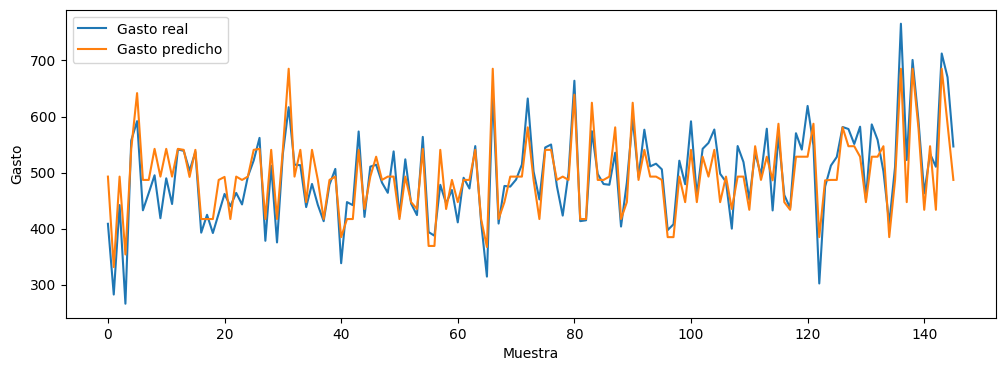

In [18]:
# Recuperar las columnas de interés: Gasto Anual y Predicción
yreal = predicciones.select('Gasto Anual').collect()
ypred = predicciones.select('Predicción').collect()

# Figuras
plt.figure(figsize=(12, 4))
plt.plot(yreal)
plt.plot(ypred)
plt.legend(['Gasto real', 'Gasto predicho'])
plt.xlabel('Muestra'); plt.ylabel('Gasto');

## 5.&nbsp;Predicción

Una vez entrenado el modelo, se puede utilizar para predecir valores para nuevos conjuntos de datos. En este caso, para realizar esta prueba, se utilizará únicamente la columna de `Atributos` del conjunto de evaluación.

In [19]:
# Datos para los cuales se realizará la predicción
df2 = test_data.select('Atributos')
df2.show(5, truncate=False)

+----------------------------------------------------------------------------+
|Atributos                                                                   |
+----------------------------------------------------------------------------+
|[29.532428967057943,10.961298400154098,37.42021557502538,4.046423164299585] |
|[30.4925366965402,11.562936246652605,35.97656497174036,1.4816166268553612]  |
|[30.57436368417137,11.351049011250833,37.08884657968332,4.078308001651641]  |
|[30.81620064887634,11.851398743073142,36.925043038878634,1.0845853030221226]|
|[31.128090049616628,13.278956228597714,37.38718052656558,4.626075291951958] |
+----------------------------------------------------------------------------+
only showing top 5 rows



In [20]:
# Predicciones sobre los datos
predicciones = modeloDT.transform(df2)

# Resultado
predicciones.show(5, truncate=False)

+----------------------------------------------------------------------------+------------------+
|Atributos                                                                   |Predicción        |
+----------------------------------------------------------------------------+------------------+
|[29.532428967057943,10.961298400154098,37.42021557502538,4.046423164299585] |492.82382368068386|
|[30.4925366965402,11.562936246652605,35.97656497174036,1.4816166268553612]  |331.41954876470464|
|[30.57436368417137,11.351049011250833,37.08884657968332,4.078308001651641]  |492.82382368068386|
|[30.81620064887634,11.851398743073142,36.925043038878634,1.0845853030221226]|353.9580918845322 |
|[31.128090049616628,13.278956228597714,37.38718052656558,4.626075291951958] |542.3249298944957 |
+----------------------------------------------------------------------------+------------------+
only showing top 5 rows

